In [1]:
!nvidia-smi

Sat May 11 22:47:13 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A5000               Off |   00000000:01:00.0 Off |                  Off |
| 30%   27C    P8             17W /  230W |       0MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
def ddpm_schedules(beta1, beta2, T):
    """
    Returns pre-computed schedules for DDPM sampling, training process.
    """
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    sqrt_beta_t = torch.sqrt(beta_t)
    alpha_t = 1 - beta_t
    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)
    oneover_sqrta = 1 / torch.sqrt(alpha_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / sqrtmab

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }

class NoiseScheduler:
    def __init__(self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02, device="cuda"):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device

        self.beta = torch.linspace(self.beta_start, self.beta_end, self.num_timesteps).to(device)
        self.sqrt_beta = torch.sqrt(self.beta)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)
        
        self.one_over_sqrt_alpha = 1 / torch.sqrt(self.alpha)
        self.sqrt_alpha_hat = torch.sqrt(self.alpha_hat)
        self.sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat)
    

    def noise_images(self, x, t):
        sqrt_alpha_hat = self.sqrt_alpha_hat[t][:, None, None, None]
        sqrt_one_minus_alpha_hat = self.sqrt_one_minus_alpha_hat[t][:, None, None, None]
        noise = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * noise, noise

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.num_timesteps, size=(n,))

    def denoise(self, noisy_image, predicted_noise, z, t):
        one_over_sqrt_alpha = self.one_over_sqrt_alpha[t]
        pred_noise_coeff = (1 - self.alpha[t])/self.sqrt_one_minus_alpha_hat[t]
        sqrt_beta = self.sqrt_beta[t]
        return (
                one_over_sqrt_alpha * (noisy_image - (pred_noise_coeff * predicted_noise))
                + sqrt_beta * z
            )

In [4]:
class UNetBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, 7, padding=3),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.conv(x)
        

class UNet(nn.Module):

    def __init__(self, num_channels):
        super().__init__()
        self.up_blocks = nn.Sequential(
            UNetBlock(num_channels, 64),
            UNetBlock(64, 128),
            UNetBlock(128, 256),
            UNetBlock(256, 512)
        )
        self.down_blocks = nn.Sequential(
            UNetBlock(512, 256),
            UNetBlock(256, 128),
            UNetBlock(128, 64)
        )
        self.out_conv = nn.Conv2d(64, num_channels, 3, padding=1)
    

    def forward(self, x, t) -> torch.Tensor:
        up_out = self.up_blocks(x)
        down_out = self.down_blocks(up_out)
        out = self.out_conv(down_out)
        return out

In [5]:
from tqdm.auto import tqdm

class Diffuser(nn.Module):
    def __init__(
        self,
        unet,
        betas,
        num_timesteps,
        eta=0.
    ):
        super().__init__()
        self.unet = unet
        self.n_T = num_timesteps
        self.criterion = nn.MSELoss()
        self.eta = eta
        for k, v in ddpm_schedules(betas[0], betas[1], num_timesteps).items():
            self.register_buffer(k, v)
        

    def forward(self, x):
        _ts = torch.randint(1, self.n_T, (x.shape[0],)).to(
            x.device
        )  # t ~ Uniform(0, n_T)
        eps = torch.randn_like(x)  # eps ~ N(0, 1)

        x_t = (
            self.sqrtab[_ts, None, None, None] * x
            + self.sqrtmab[_ts, None, None, None] * eps
        )  # This is the x_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this x_t. Loss is what we return.

        return self.criterion(eps, self.unet(x_t, _ts / self.n_T))

   
    def sample(self, n_sample: int, size, device) -> torch.Tensor:

        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1)

        # This samples accordingly to Algorithm 2. It is exactly the same logic.
        for i in tqdm(range(self.n_T, 0, -1), desc="Sampling images", leave=False):
            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0
            eps = self.unet(x_i, i / self.n_T)
            x_i = (
                self.oneover_sqrta[i] * (x_i - eps * self.mab_over_sqrtmab[i])
                + self.sqrt_beta_t[i] * z
            )

        return x_i

    def sample_ddim(self, n_sample: int, size, device) -> torch.Tensor:
        x_i = torch.randn(n_sample, *size).to(device)  # x_T ~ N(0, 1)

        for i in tqdm(range(self.n_T, 1, -1), desc="Sampling images", leave=False):
            z = torch.randn(n_sample, *size).to(device) if i > 1 else 0
            eps = self.unet(x_i, torch.tensor(i / self.n_T).to(device).repeat(n_sample, 1))
            x0_t = (x_i - eps * (1 - self.alphabar_t[i]).sqrt()) / self.alphabar_t[i].sqrt()
            c1 = self.eta * ((1 - self.alphabar_t[i] / self.alphabar_t[i - 1]) * (1 - self.alphabar_t[i - 1]) / (
                    1 - self.alphabar_t[i])).sqrt()
            c2 = ((1 - self.alphabar_t[i - 1]) - c1 ** 2).sqrt()
            x_i = self.alphabar_t[i - 1].sqrt() * x0_t + c1 * z + c2 * eps

        return x_i

In [6]:
# class Diffuser(nn.Module):
#     def __init__(
#         self,
#         unet,
#         noise_scheduler,
#         num_timesteps
#     ):
#         super().__init__()
#         self.unet = unet
#         self.noise_scheduler = noise_scheduler
#         self.num_timesteps = num_timesteps
#         self.criterion = nn.MSELoss()
        

#     def forward(self, x):
#         timesteps = torch.randint(1, self.num_timesteps, (x.shape[0],)).to(x.device)
#         noisy_x, noise = self.noise_scheduler.noise_images(x, timesteps)
#         predicted_noise = self.unet(noisy_x, timesteps/self.num_timesteps)
#         return self.criterion(noise, predicted_noise)

   
#     def sample(self, n_samples, size, device):

#         x = torch.randn(n_samples, *size).to(device)
        
#         for t in range(self.num_timesteps, 0, -1):
#             z = torch.randn(n_samples, *size).to(device) if t > 1 else 0
#             predicted_noise = self.unet(x, t / self.num_timesteps)
#             x = self.noise_scheduler.denoise(x, predicted_noise, z, t-1)
#         return x

In [7]:
from datasets import load_dataset
from torchvision import transforms
from PIL import Image

dataset = load_dataset("ceyda/smithsonian_butterflies", split="train[:1000]")

img_size = 32
# preprocess = transforms.Compose(
#     [
#         transforms.Resize((img_size, img_size)),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.5], [0.5]),
#     ]
# )
preprocess = transforms.Compose(  # resize to 512 x 512, convert to tensor, normalize
    [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

In [8]:
from torch.optim import Adam
from tqdm.auto import tqdm, trange
from torchvision.utils import save_image, make_grid


train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0)
num_epochs = 20

device = "cuda"
global_step = 0
sample_every = 100
num_timesteps = 500
num_channels = 3
unet = UNet(num_channels).to(device)
ddpm_model = Diffuser(unet, [1e-4, 0.02], num_timesteps, eta=0.5).to(device)

optimizer = torch.optim.Adam(ddpm_model.parameters(), lr=1e-3)


for i in trange(num_epochs, desc="Epoch"):
    ddpm_model.train()


    with tqdm(train_dataloader, desc="Training loop") as progress_bar:
        avg_loss = None
        for batch in progress_bar:
            optimizer.zero_grad()
            x = batch["images"].to(device)
            
            loss = ddpm_model(x)
            loss.backward()
            if avg_loss is None:
                avg_loss = loss.item()
            else:
                avg_loss = 0.9 * avg_loss + 0.1 * loss.item()
            progress_bar.set_postfix(loss=f"{avg_loss:.4f}")
            optimizer.step()
            global_step += 1
    
            
        
            if global_step % sample_every == 0:
                ddpm_model.eval()
                with torch.no_grad():
                    x_gen = ddpm_model.sample_ddim(8, (3, img_size, img_size), device)
                    x_all = torch.cat([x_gen, x[:8]], dim=0)
                    grid = make_grid(x_all, normalize=True, value_range=(-1, 1), nrow=4)
                    save_image(grid, f"./samples/step_{global_step}.png")
    
                    torch.save(ddpm_model.state_dict(), f"./models/ddpm_model_latest.pth")


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training loop:   0%|          | 0/16 [00:00<?, ?it/s]

/nfshomes/skarki/scratch/miniconda3/envs/unsloth_env/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/nfshomes/skarki/scratch/miniconda3/envs/unsloth_env/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Training loop:   0%|          | 0/16 [00:00<?, ?it/s]

Training loop:   0%|          | 0/16 [00:00<?, ?it/s]

Training loop:   0%|          | 0/16 [00:00<?, ?it/s]

Training loop:   0%|          | 0/16 [00:00<?, ?it/s]

Training loop:   0%|          | 0/16 [00:00<?, ?it/s]

Training loop:   0%|          | 0/16 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/16 [00:00<?, ?it/s]

Training loop:   0%|          | 0/16 [00:00<?, ?it/s]

Training loop:   0%|          | 0/16 [00:00<?, ?it/s]

Training loop:   0%|          | 0/16 [00:00<?, ?it/s]

Training loop:   0%|          | 0/16 [00:00<?, ?it/s]

Training loop:   0%|          | 0/16 [00:00<?, ?it/s]

Sampling images:   0%|          | 0/499 [00:00<?, ?it/s]

Training loop:   0%|          | 0/16 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [29]:
import matplotlib.pyplot as plt

def train(data_loader, n_epoch: int = 1000, device: str = "cuda:0") -> None:
    # Initializing the DDIM model with a specified U-Net architecture, beta values, and timesteps
    num_channels = 3
    unet = UNet(num_channels).to(device)
    ddpm_model = Diffuser(
        unet,
        (1e-4, 0.02),
        num_timesteps=500,
        eta=0.5,
    )
    ddpm_model.to(device)

    # Setting up the optimizer for training (Adam optimizer with a learning rate of 1e-5)
    optimizer = torch.optim.Adam(ddpm_model.parameters(), lr=1e-3)

    # Create a list to store the average loss of each epoch
    epoch_losses = []

    # Setting up the plot
    fig, ax = plt.subplots()
    display_handle = display(fig, display_id=True)

    # Main training loop
    for epoch in tqdm(range(n_epoch), desc="Processing epoch", leave=False):
        ddpm_model.train()  # Setting the model to training mode

        pbar = tqdm(data_loader, desc="Training loop", leave=False)
        batch_losses = []  # List to store the loss of each batch
        for batch, _ in pbar:
            optimizer.zero_grad()  # Zeroing the gradients
            # x = batch["images"].to(device)
            x = batch.to(device)
            loss = ddpm_model(x)  # Forward pass to compute the loss
            loss.backward()  # Backward pass to compute gradients
            nn.utils.clip_grad_norm_(ddpm_model.parameters(), 1.0)
            optimizer.step()  # Update model parameters

            # Store the loss of each batch
            batch_losses.append(loss.item())
            pbar.set_postfix(loss=f"{loss.item():.4f}")

        # Calculate and store the average loss of the epoch
        epoch_avg_loss = sum(batch_losses) / len(batch_losses)
        epoch_losses.append(epoch_avg_loss)

        # Clear the previous plot and plot the updated epoch_losses
        ax.clear()
        ax.plot(epoch_losses, label="Epoch Loss")
        ax.legend()
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_title(f"Training Loss up to Epoch {epoch + 1}")
        ax.grid(True)

        # Redraw the plot
        display_handle.update(fig)

        # Evaluation and sample generation
        ddpm_model.eval()
        with torch.no_grad():
            if epoch % 1 == 0:
                samples = ddpm_model.sample_ddim(8, (3, 32, 32), device)
                sample_set = torch.cat([samples, x[:8]], dim=0)
                grid = make_grid(
                    sample_set, normalize=True, value_range=(-1, 1), nrow=4
                )
                save_image(grid, f"./samples/ddim_sample_{epoch}.png")

            # Saving the model weights
            torch.save(ddpm_model.state_dict(), "./models/ddim_weights.pth")

    plt.close()

In [30]:
from torchvision.datasets import CIFAR10
tf = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)


dataset = CIFAR10(
    "./data",
    train=True,
    download=True,
    transform=tf,
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True, num_workers=0)

Files already downloaded and verified


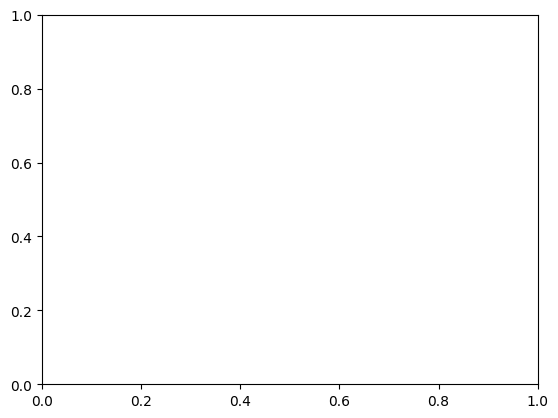

Processing epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Training loop:   0%|          | 0/196 [00:00<?, ?it/s]

/nfshomes/skarki/scratch/miniconda3/envs/unsloth_env/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/nfshomes/skarki/scratch/miniconda3/envs/unsloth_env/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


KeyboardInterrupt: 

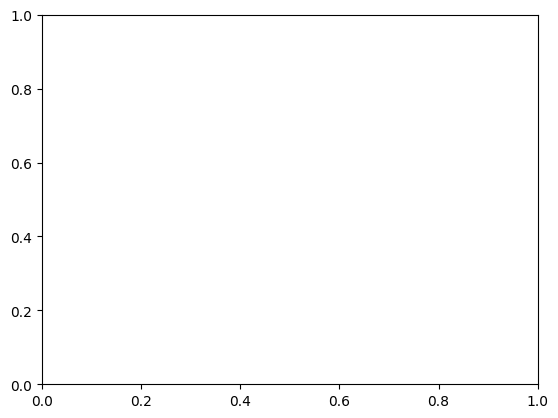

In [31]:
train(data_loader=dataloader, n_epoch=100, device="cuda:0")

In [11]:
# from torch.optim import Adam
# from tqdm.auto import tqdm, trange


# train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)
# num_epochs = 20

# device = "cuda"
# global_step = 0
# sample_every = 100
# num_timesteps = 1000
# num_channels = 3
# unet = UNet(num_channels).to(device)
# noise_scheduler = NoiseScheduler(num_timesteps, device=device)
# ddpm_model = Diffuser(unet, noise_scheduler, num_timesteps)

# optimizer = torch.optim.Adam(ddpm_model.parameters(), lr=2e-4)


# for i in trange(num_epochs, desc="Epoch"):
#     ddpm_model.train()


#     with tqdm(train_dataloader, desc="Training loop") as progress_bar:
#         avg_loss = None
#         for batch in progress_bar:
#             optimizer.zero_grad()
#             x = batch["images"].to(device)
            
#             loss = ddpm_model(x)
#             loss.backward()
#             if avg_loss is None:
#                 avg_loss = loss.item()
#             else:
#                 avg_loss = 0.9 * avg_loss + 0.1 * loss.item()
#             progress_bar.set_postfix(loss=f"{avg_loss:.4f}")
#             optimizer.step()
#             global_step += 1
    
#         if global_step % sample_every == 0:
#             ddpm_model.eval()
#             with torch.no_grad():
#                 x_gen = ddpm_model.sample(16, (1, img_size, img_size), device)
#                 grid = make_grid(x_gen, nrow=4)
#                 save_image(grid, f"./samples/step_{global_step}.png")
        
#                 torch.save(ddpm_model.state_dict(), f"./ddpm_model_step_{global_step}.pth")


In [8]:
x_gen = ddpm_model.sample(4, (3, img_size, img_size), device)
grid = make_grid(x_gen, nrow=4)
save_image(grid, f"./samples/step_{global_step}.png")

torch.save(ddpm_model.state_dict(), f"./ddpm_model_step_{global_step}.pth")

/nfshomes/skarki/scratch/miniconda3/envs/unsloth_env/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 4.13 GiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
/nfshomes/skarki/scratch/miniconda3/envs/unsloth_env/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 74.00 MiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
/nfshomes/skarki/scratch/miniconda3/envs/unsloth_env/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 106.00 MiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, w

OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 